In [60]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
plt.style.use("ggplot")



In [61]:
import keras
import tensorflow as tf

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical,np_utils
from keras import backend

from keras.models import Model, Input, Sequential,model_from_json
from keras.layers import SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
                         Dropout, Bidirectional, Conv1D, BatchNormalization

print(keras.__version__)
print(tf.__version__)

2.3.1
2.0.0


In [62]:
# Set seed for repeatable results
np.random.seed(123)
tf.random.set_seed(456)

In [63]:
from sklearn.metrics import classification_report
import seaborn as sns

Step 1 
Read ALL DATA


Essential info about entities:
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

IOB prefix:
* B: beginning of named entity
* I: inside of named entity
* O: outside of named entity

In [64]:
path_dataset = './data/ner_dataset.csv'
data = pd.read_csv(path_dataset, encoding="latin1")
data = data.fillna(method="ffill")
pd.options.display.max_rows = 999
data.head(15)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [65]:
words = data.Word.unique()

In [66]:
words.sort()

In [67]:
np.where(words=='asking')

(array([17752]),)

In [68]:
words = np.append(words, "ENDPAD")

In [69]:
n_words = len(words)

In [70]:
n_sentences = len(data.groupby('Sentence #'))

In [71]:
tags = data.Tag.unique()
tags.sort()

In [72]:
tags = np.append(tags, "PAD")

In [73]:
n_tags = len(tags)

In [74]:
print('We have {} sentences containing {} unique words with {} different tags.'.format(n_sentences, n_words, n_tags))

We have 47959 sentences containing 35179 unique words with 18 different tags.


In [75]:
print('We have the following Tags: ', tags)

We have the following Tags:  ['B-art' 'B-eve' 'B-geo' 'B-gpe' 'B-nat' 'B-org' 'B-per' 'B-tim' 'I-art'
 'I-eve' 'I-geo' 'I-gpe' 'I-nat' 'I-org' 'I-per' 'I-tim' 'O' 'PAD']


In [76]:
data.Tag.value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

In [77]:
sentence_list = []
max_len = 0
for i, sentence in data.groupby('Sentence #')[['Word', 'Tag']]:
    l = [(x, y) for x, y in zip(sentence.Word, sentence.Tag)]
    sentence_list.append(l)
    max_len = max(max_len, len(l))

In [78]:
print('A sentence: ', sentence_list[100])

A sentence:  [('She', 'O'), ('was', 'O'), ('a', 'O'), ('longtime', 'O'), ('member', 'O'), ('of', 'O'), ('the', 'O'), ('Zapatista', 'B-geo'), ('movement', 'O'), ('and', 'O'), ('appeared', 'O'), ('in', 'O'), ('public', 'O'), ('wearing', 'O'), ('a', 'O'), ('black', 'O'), ('ski', 'O'), ('mask', 'O'), ('.', 'O')]


In [79]:
print('Longest sentence length: ', max_len)

Longest sentence length:  104


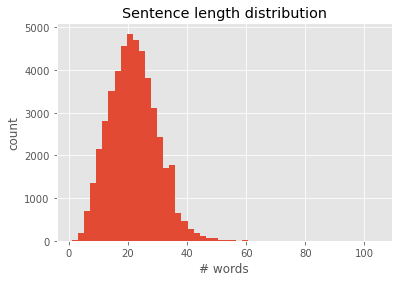

In [80]:
plt.hist([len(s) for s in sentence_list], bins=50)
plt.title('Sentence length distribution')
plt.xlabel('# words')
plt.ylabel('count')
plt.show()

In [81]:
word2idx = {word: idx for idx, word in enumerate(words)}
idx2word = {idx: word for idx, word in enumerate(words)}

In [82]:
print('The index of the work `{}` is {}'.format('Park', word2idx['Park']))

The index of the work `Park` is 11931


In [83]:
X = [[word2idx[w[0]] for w in s] for s in sentence_list]

In [84]:
X = pad_sequences(sequences=X, maxlen=max_len, padding='post', value=n_words-1)

In [85]:
print('The padded sequence for the sentence 0 is: ', X[0])

The padded sequence for the sentence 0 is:  [15077 27700 20969 24218 26434 33389  9684 33464 29396 33246 34660 24853
  8204 17364 20924 33246 34973 27700  4010 33786 23512 33242 20368    24
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]


In [86]:
tag2idx = {tag: idx for idx, tag in enumerate(tags)}
idx2tag = {idx: tag for idx, tag in enumerate(tags)}

In [87]:
print('The index of the tag `{}` is {}'.format('B-geo', tag2idx['B-geo']))

The index of the tag `B-geo` is 2


In [88]:
y = [[tag2idx[w[1]] for w in s] for s in sentence_list]

In [89]:
y = pad_sequences(sequences=y, maxlen=max_len, padding='post', value=tag2idx['PAD'])

In [90]:
print('The padded tags for the sentence 0 is: ', y[0])

The padded tags for the sentence 0 is:  [16 16 16 16 16 16  2 16 16 16 16 16  2 16 16 16 16 16  3 16 16 16 16 16
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17]


In [91]:
y = np.array([to_categorical(i, num_classes=n_tags) for i in y])

In [92]:
y.shape

(47959, 104, 18)

In [93]:
print('The padded categorical tags for the sentence 0 is: ', y[0])

The padded categorical tags for the sentence 0 is:  [[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)

In [95]:
print("The index of word 'Harvard' is: {}\n".format(word2idx["Harvard"]))
print("Sentence 1: {}\n".format(X[1]))
print(X.shape)

The index of word 'Harvard' is: 7506

Sentence 1: [ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]

(47959, 104)


In [96]:
print("The index of tag 'B-gpe' is: {}\n".format(tag2idx["B-gpe"]))
print("The tag of the last word in Sentence 1: {}\n".format(y[0][-1]))
print(np.array(y).shape)

The index of tag 'B-gpe' is: 3

The tag of the last word in Sentence 1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

(47959, 104, 18)


In [97]:
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./models/{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")
    
# Plot history
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [98]:
def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./models/{}.h5".format(model_name))
    return model

In [99]:
n_units = 100
drop_rate = .1
dim_embed = 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

In [100]:
model_rnn=Sequential()
model_rnn.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model_rnn.add(Dropout(drop_rate))
model_rnn.add(SimpleRNN(dim_embed, return_sequences=True))
model_rnn.add(TimeDistributed(Dense(n_tags, activation='softmax')))
# Compile model
model_rnn.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [101]:
history_rnn = model_rnn.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 274s 7ms/step - loss: 0.0954 - accuracy: 0.9774 - val_loss: 0.0337 - val_accuracy: 0.9902
Epoch 2/10
38846/38846 [==============================] - 261s 7ms/step - loss: 0.0299 - accuracy: 0.9912 - val_loss: 0.0290 - val_accuracy: 0.9914
Epoch 3/10
38846/38846 [==============================] - 268s 7ms/step - loss: 0.0262 - accuracy: 0.9922 - val_loss: 0.0277 - val_accuracy: 0.9918
Epoch 4/10
38846/38846 [==============================] - 261s 7ms/step - loss: 0.0244 - accuracy: 0.9927 - val_loss: 0.0272 - val_accuracy: 0.9920
Epoch 5/10
38846/38846 [==============================] - 263s 7ms/step - loss: 0.0234 - accuracy: 0.9931 - val_loss: 0.0272 - val_accuracy: 0.9920
Epoch 6/10
38846/38846 [==============================] - 271s 7ms/step - loss: 0.0225 - accuracy: 0.9933 - val_loss: 0.0266 - val_accuracy: 0.9922
Epoch 7/10
38846/38846 [==============================] - 302s 

In [102]:
# save your mode ##
store_keras_model(model_rnn, 'model_RNN')

Saved model to disk


In [103]:
# run this cell to show your results #
print(model_rnn.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_4 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 104, 50)           5050      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 104, 18)           918       
Total params: 1,764,918
Trainable params: 1,764,918
Non-trainable params: 0
_________________________________________________________________
None


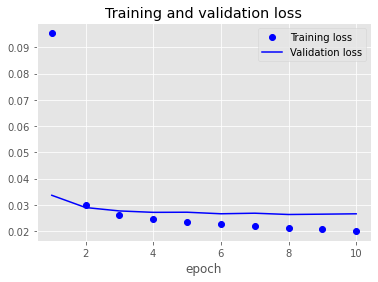

In [104]:
# run this cell to show your results #
plot_training_history(history_rnn)

In [105]:
def truncate_and_visualize(trained_model, truncated_model, truncated_output_dim, X, y):
    # set weights of first few layers using the weights of trained model
    for i, layer in enumerate(truncated_model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    truncated_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    # predict using the first few layers
    hidden_features = truncated_model.predict(X)
    # flatten data
    hidden_features=hidden_features.reshape(-1,truncated_output_dim)
    y=y.reshape(-1,18)
    # find first two PCA components
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(hidden_features)
    print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
    # visualize hidden featurs on first two PCA components
    color=['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y, axis=1)
    fig, ax = plt.subplots(1,2,figsize=(15,6))
    #fig.set_size_inches(6,6)    
    for cat in range(8):
        indices_B = np.where(category==cat)[0]
        ax[0].scatter(pca_result[indices_B,0], pca_result[indices_B, 1], label=idx2tag[cat],s=2,color=color[cat],alpha=0.5)
        legend=ax[0].legend(markerscale=3)
        legend.get_frame().set_facecolor('w')  
    for cat in range(8, 16):
        indices_B = np.where(category==cat)[0]
        ax[1].scatter(pca_result[indices_B,0], pca_result[indices_B, 1], label=idx2tag[cat],s=2,color=color[cat-8],alpha=0.5)
        legend=ax[1].legend(markerscale=3)
        legend.get_frame().set_facecolor('w')  
    plt.show()

Variance explained by PCA: 0.8465930807538605


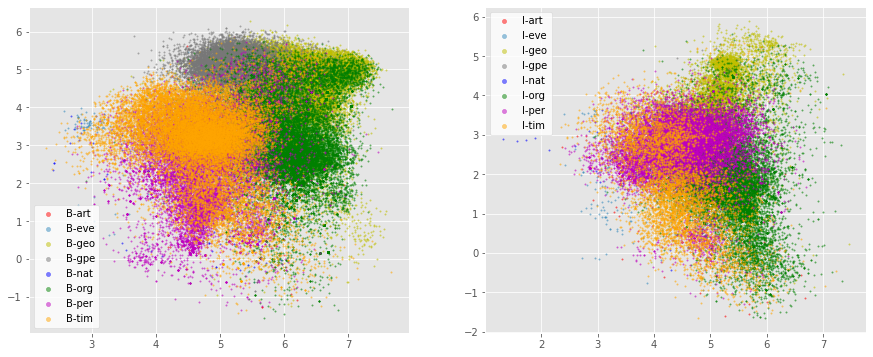

In [106]:
# visualization of hidden features

RNN=load_keras_model('model_RNN')
model=Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))
model.add(SimpleRNN(dim_embed, return_sequences=True))
truncate_and_visualize(trained_model=RNN, truncated_model=model, truncated_output_dim=dim_embed, X=X_train, y=y_train)

In [113]:
def compute_f1_score(model_name, X, y):
    model = load_keras_model(model_name)
    preds = model.predict(X)
    pred_labels = pred2label(preds)
    print("{}: F1-score: {:.1%}".format(model_name, f1_score(y, pred_labels, average='weighted')))
    f1_scores = classification_report(y, pred_labels, output_dict=True)
    df = pd.DataFrame(f1_scores)[tags].reset_index().rename(columns={'index': 'Metric'})
    df = pd.melt(df, id_vars=["Metric"], 
                       var_name="Tag", value_name="Value")
    df = df[['Tag', 'Metric','Value']]
    df['Model'] = model_name
    return df, pred_labels

In [114]:
def pred2label(pred):
    labels = []
    for pred_i in pred:
        label = []
        for p in pred_i:
            p_i = np.argmax(p)
            label.append(idx2tag[p_i])
        labels.append(label)
    return np.array(labels).flatten()

In [115]:
import warnings
warnings.filterwarnings('ignore') 

test_labels = pred2label(y_test)
df_predictions = pd.DataFrame()
df_predictions['Word'] = [idx2word[w] for w in X_test.reshape(-1,)]
df_predictions['y_true'] = test_labels

df_f1_scores = pd.DataFrame(columns=['Model', 'Tag', 'Metric', 'Value'])

f1, pred_labels = compute_f1_score('model_RNN', X_test, test_labels)
df_f1_scores = df_f1_scores.append(f1, sort=False)
df_predictions['model_RNN'] = pred_labels

model_RNN: F1-score: 99.2%


In [116]:
df_predictions[df_predictions['Word']!='ENDPAD'].head(150)

,Word,y_true,model_RNN
0,Nasser,B-per,B-per
1,al-Kidwa,I-per,I-per
2,",",O,O
3,who,O,O
4,also,O,O
5,is,O,O
6,the,O,O
7,Palestinian,B-gpe,B-gpe
8,representative,O,O
9,to,O,O


In [117]:
def highlight_errors(s):
    is_max = s == s.y_true
    return ['' if v or key=='Word' else 'color: red' for key,v in is_max.iteritems()]

In [118]:
df_predictions_wrong = df_predictions[df_predictions.y_true!=df_predictions.model_RNN]

In [119]:
df_predictions_wrong.style.apply(highlight_errors, axis=1)

In [120]:
len(df_predictions_wrong)

3975

In [121]:
len(df_predictions)

498784